In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
df = pd.read_csv('/Users/patrickfahy99/Documents/Kaggle_datasets/training.1600000.processed.noemoticon.csv',
                   encoding='ISO-8859-1',
                   names=['target', 'ids', 'date', 'flag', 'user', 'text'])

In [3]:
df = df.drop(['ids','date','flag', 'user'], axis=1)

In [4]:
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
d = {0: 'NEGATIVE', 2: 'NEUTRAL', 4: 'POSITIVE'}
df.target = df.target.apply(lambda x: d[int(x)])
df

,target,text
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,is upset that he can't update his Facebook by ...
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,my whole body feels itchy and like its on fire
4,NEGATIVE,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,POSITIVE,Just woke up. Having no school is the best fee...
1599996,POSITIVE,TheWDB.com - Very cool to hear old Walt interv...
1599997,POSITIVE,Are you ready for your MoJo Makeover? Ask me f...
1599998,POSITIVE,Happy 38th Birthday to my boo of alll time!!! ...


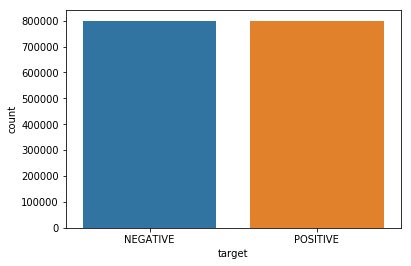

In [6]:
sns.countplot(df.target)

In [7]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickfahy99/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/patrickfahy99/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
df.text = df.text.apply(lambda x: x.lower())

In [9]:
df.text = df.text.apply(lambda x: ' '.join(x.split('@')))

In [10]:
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [11]:
stop_words = stopwords.words("english")
stop_words.remove('not')
stemmer = SnowballStemmer("english")

In [12]:
import re

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
df.text = df.text.apply(lambda x: preprocess(x))

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

In [15]:
documents = [_text.split() for _text in df_train.text] 

In [16]:
import gensim

w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [17]:
w2v_model.build_vocab(documents)

In [18]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 40176


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

CPU times: user 21min 2s, sys: 9.75 s, total: 21min 12s
Wall time: 7min 8s


(307456046, 357073568)

In [20]:
w2v_model.most_similar("love")

/Users/patrickfahy99/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5800167322158813),
 ('loves', 0.5583100318908691),
 ('adore', 0.5514630079269409),
 ('loved', 0.5323922634124756),
 ('amazing', 0.4960470497608185),
 ('looove', 0.4956216812133789),
 ('loooove', 0.46301648020744324),
 ('looooove', 0.4469304084777832),
 ('lovee', 0.4462384581565857),
 ('awesome', 0.43657630681991577)]

In [21]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 555585


In [22]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

In [23]:
labels = df_train.target.unique().tolist()
labels.append('NEUTRAL')
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [25]:
print("y_train",y_train.shape)
print("y_test",y_test.shape)

print("x_train", x_train.shape)
print("x_test", x_test.shape)

y_train (1440000, 1)
y_test (160000, 1)
x_train (1440000, 300)
x_test (160000, 300)


In [26]:
y_train[:10]

array([[1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [27]:
# Embedding layer

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(555585, 300)


In [28]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

In [29]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [30]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          166675500 
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 166,836,001
Trainable params: 160,501
Non-trainable params: 166,675,500
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [32]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [33]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [34]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1266/1266 [==============================] - 12107s 10s/step - loss: 0.4942 - accuracy: 0.7577 - val_loss: 0.4539 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 2/8
1266/1266 [==============================] - 15226s 12s/step - loss: 0.4675 - accuracy: 0.7754 - val_loss: 0.4445 - val_accuracy: 0.7923 - lr: 0.0010
Epoch 3/8
1266/1266 [==============================] - 9582s 8s/step - loss: 0.4602 - accuracy: 0.7796 - val_loss: 0.4403 - val_accuracy: 0.7939 - lr: 0.0010
Epoch 4/8
1266/1266 [==============================] - 9397s 7s/step - loss: 0.4566 - accuracy: 0.7818 - val_loss: 0.4388 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 5/8
1266/1266 [==============================] - 9566s 8s/step - loss: 0.4539 - accuracy: 0.7835 - val_loss: 0.4365 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 6/8
1266/1266 [==============================] - 9459s 7s/step - loss: 0.4521 - accuracy: 0.7848 - val_loss: 0.4352 - val_accuracy: 0.7971 - lr: 0.0010
Epoch 7/8
1266/1266 [===========================

In [35]:
%%time
score = model.evaluate(x_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

157/157 [==============================] - 246s 2s/step - loss: 0.4298 - accuracy: 0.7998

ACCURACY: 0.7998375296592712
LOSS: 0.42978209257125854
CPU times: user 10min 28s, sys: 2min 45s, total: 13min 13s
Wall time: 4min 7s


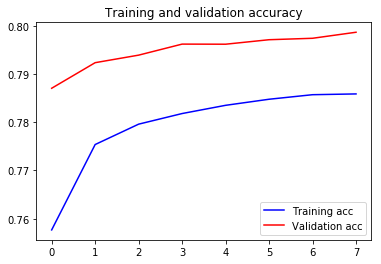

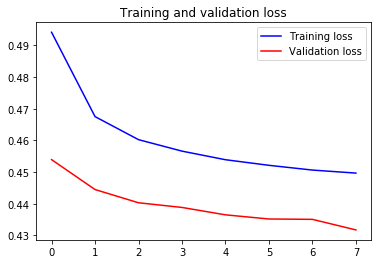

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [37]:
SENTIMENT_THRESHOLDS = (0.25, 0.75)

def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [38]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [39]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

20/20 [==============================] - 260s 13s/step


In [40]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

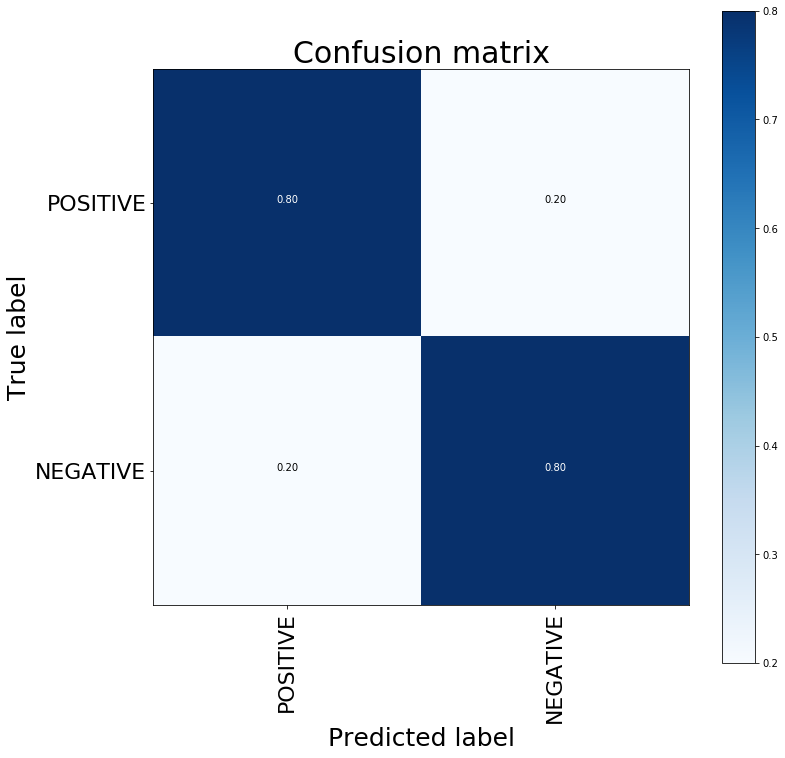

CPU times: user 1.14 s, sys: 667 ms, total: 1.8 s
Wall time: 2.69 s


In [41]:
%%time

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [42]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.80      0.80     79812
    POSITIVE       0.80      0.80      0.80     80188

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



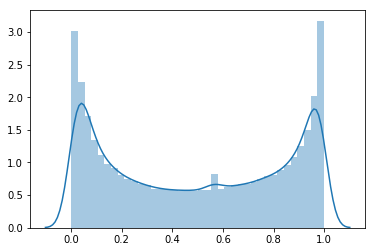

In [43]:
sns.distplot(scores)

In [44]:
accuracy_score(y_test_1d, y_pred_1d)

0.7998375

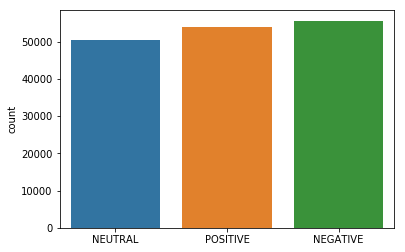

In [45]:
y_pred = [decode_sentiment(score, include_neutral=True) for score in scores]
sns.countplot(y_pred)

In [46]:
predict('football')

{'label': 'NEUTRAL',
 'score': 0.550987720489502,
 'elapsed_time': 0.6058590412139893}

In [47]:
df

,target,text
0,NEGATIVE,switchfoot awww bummer shoulda got david carr ...
1,NEGATIVE,upset update facebook texting might cry result...
2,NEGATIVE,kenichan dived many times ball managed save 50...
3,NEGATIVE,whole body feels itchy like fire
4,NEGATIVE,nationwideclass not behaving mad see
...,...,...
1599995,POSITIVE,woke school best feeling ever
1599996,POSITIVE,thewdb com cool hear old walt interviews
1599997,POSITIVE,ready mojo makeover ask details
1599998,POSITIVE,happy 38th birthday boo alll time tupac amaru ...


In [48]:
import pickle

model.save('modelnlp.h5')
w2v_model.save('model.w2v')
pickle.dump(tokenizer, open('tokenizer.pkl', "wb"), protocol=0)
pickle.dump(encoder, open('encoder.pkl', "wb"), protocol=0)